In [1]:
cd ..

/home/mars/mount/src_aiai


In [6]:
import time
import tqdm 
import sparse


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from scipy.special import iv, jv
from scipy.sparse import *

In [7]:
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op, NUFFT_op_TF, old_NUFFT_op, old_NUFFT_op_TF, calculate_kaiser_bessel_coef
from src.visualisation import compare

In [8]:
uv = spider_sampling()

In [9]:
Nd = (256,256)
Kd = (512, 512)
Jd = (6,6)

## KB coefficients

In [10]:
gridsize = 2*np.pi / Kd[0]
k = (uv + np.pi) / gridsize
kx = (uv[:,0] + np.pi) // gridsize
ky = (uv[:,1] + np.pi) // gridsize

In [11]:
c = calculate_kaiser_bessel_coef(k[0], 0)

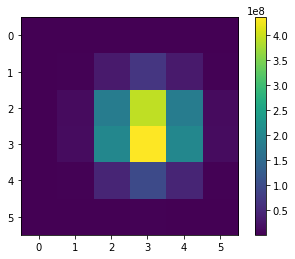

In [12]:
plt.imshow(c[-1].reshape(6,6))
plt.colorbar()

## NUFFT Operator

In [13]:
class Op():
    def __init__(self):
        pass
        # TODO select axes over which to perform fft (and padding operations)
        # TODO add scaling 
        # TODO check coeficient calculation
        
    def plan(self, uv, Nd, Kd, Jd):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        indices = np.array(indices).reshape(-1, 4)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
    
        J = Jd[0] #np.linalg.norm(Jd)
        beta = 2.34*J
        s_kb = lambda x: np.sinc(np.sqrt((np.pi *x *J)**2 - (2.34*J)**2 +0j)/np.pi)

        xx = (np.arange(Kd[0])/Kd[0] -.5)[Kd[0]//4:-Kd[0]//4]
        sa = s_kb(xx).real
        self.scaling = (sa.reshape(-1,1) * sa.reshape(1,-1))
#         self.scaling = 1

    def forward(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx/self.scaling).reshape(-1, self.Nd[0], self.Nd[1])))))  # why divide on both sides?
#         return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx).reshape(-1, self.Nd[0], self.Nd[1]))*self.scaling))) 
    
    def adjoint(self, k):
        return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0], self.Kd[1])).sum(axis=(2,3)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(kk, axes=(-2,-1)), axes=(-2,-1), norm=None), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xx, axes=(-2,-1)), axes=(-2,-1), norm=None), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ( (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2)
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

In [14]:
op = NUFFT_op()
op.plan(uv, Nd=(256,256), Kd=(512,512), Jd=(6,6))

100%|████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 5209.74it/s]


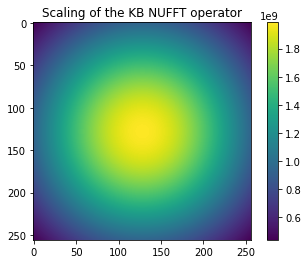

In [15]:
plt.imshow(op.scaling.real)
plt.title("Scaling of the KB NUFFT operator")
plt.colorbar()

## Compare Direct FT vs min-max NUFFT vs KB NUFFT



In [16]:
def dft(x, w, m):
    
    return np.array([np.sum(m * np.exp(1j*w*i)) for i in x ])

def dft2(x1, x2, w, m):
   
    w1 = np.exp(1j * w[:,0])
    w2 = np.exp(1j * w[:,1])
    N = len(x1)
    res = np.zeros((len(x1), len(x2)))
    for i in tqdm.tqdm(range(len(x1))):
        for j in range(len(x2)):
            res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
    return res/(2*N)**2

In [17]:
# using (slow) non-uniform direct fourier transform
x_dirty_ndft = dft2(np.arange(-128,128), np.arange(-128,128), uv, np.ones(len(uv)))

  0%|                                                              | 0/256 [00:00<?, ?it/s]<ipython-input-16-2d6e30a2d649>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,j] = np.sum( w1**(x1[i]) * w2**(x2[j]) *m)
100%|████████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.33it/s]


In [18]:
# old Min Max Nufft
old_op = old_NUFFT_op(uv)

In [22]:
y = np.ones((4440,1)) +0j

st = time.perf_counter()
x_dirty_kb = op.adj_op(y).real # kaiser bessel
t_kb = time.perf_counter() - st

st = time.perf_counter()
x_dirty_mm = old_op.adj_op(y).real # min max
t_mm = time.perf_counter() - st

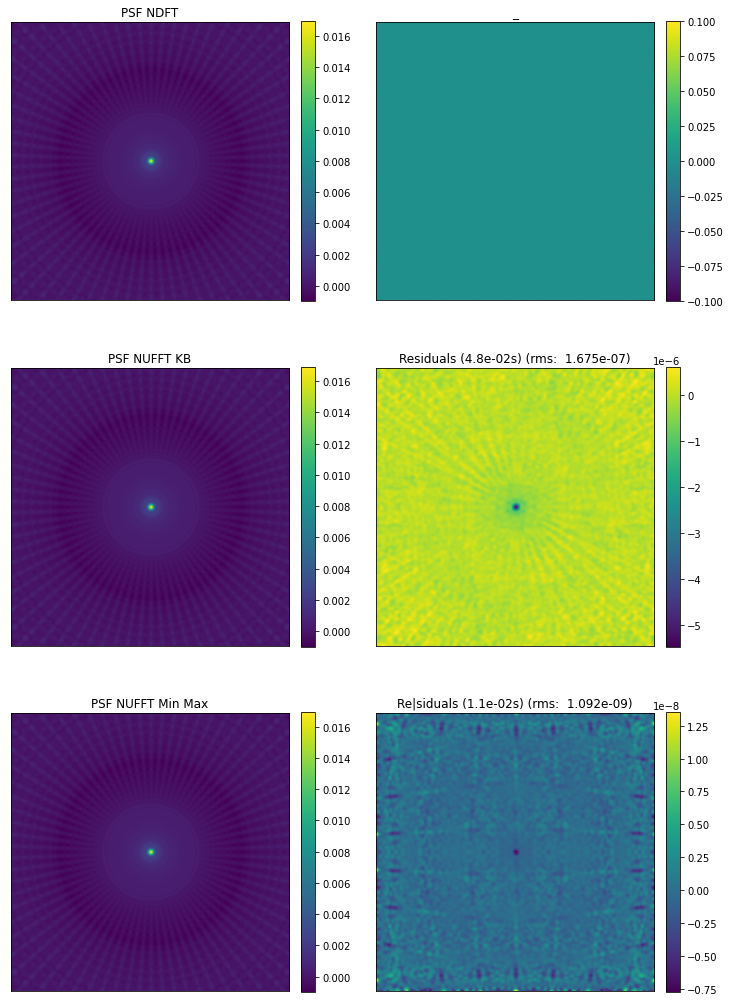

In [23]:
compare([
    x_dirty_ndft, np.zeros(Nd),
    x_dirty_kb, x_dirty_kb - x_dirty_ndft, 
    x_dirty_mm, x_dirty_mm - x_dirty_ndft], ncols=2, nrows=3, 
    titles=[
        "PSF NDFT", "_", 
        "PSF NUFFT KB", f"Residuals ({t_kb:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_kb))):.3e})",
        "PSF NUFFT Min Max", f"Re|siduals ({t_mm:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_mm))):.3e})"
    ], colorbar=True)

## TF numpyfunc vs TF Native

In [1]:
%load_ext line_profiler

In [2]:
import tensorflow as tf
from src.operators.measurement import NUFFT_op, NUFFT_op_TF
import time
import numpy as np
from src.visualisation import compare

In [3]:
from src.sampling.uv_sampling import spider_sampling
uv = spider_sampling()
Nd = (256,256)
Kd = (512, 512)
Jd = (6,6)

In [4]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [5]:
class TF_nufft(NUFFT_op):
    """ Tensorfow adaptation of the nufft operator""" 
    def forward(self, x):
        return tf.numpy_function(self.dir_op, [x], tf.complex64)
    def adjoint(self, x):
        return tf.numpy_function(self.adj_op, [x], tf.complex64)

In [24]:
tf_kb = NUFFT_op_TF()
tf_kb.plan(uv, Nd, Kd, Jd, batch_size=20)

100%|████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 4897.30it/s]


In [7]:
tf_kb.interp_matrix.shape

TensorShape([1, 4440, 512, 512])

In [8]:
tf_kb2 = TF_nufft()
tf_kb2.plan(uv, Nd, Kd, Jd)

100%|████████████████████████████████████████████████| 4440/4440 [00:00<00:00, 5351.48it/s]


In [21]:
y_tf = tf.convert_to_tensor(np.ones((20, 4440)) +1j)

In [25]:
%%time
tf.cast(y_tf, tf.complex64)

CPU times: user 321 µs, sys: 105 µs, total: 426 µs
Wall time: 311 µs


<tf.Tensor: shape=(20, 4440), dtype=complex64, numpy=
array([[1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j],
       [1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j],
       [1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j],
       ...,
       [1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j],
       [1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j],
       [1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j]],
      dtype=complex64)>

In [26]:
st = time.perf_counter()
%lprun -f tf_kb.adj_op x_dirty_tf_kb = tf_kb.adj_op(y_tf)
t_kb = time.perf_counter() - st

Timer unit: 1e-06 s

Total time: 2.25496 s
File: /home/mars/mount/src_aiai/src/operators/measurement.py
Function: adj_op at line 207

Line #      Hits         Time  Per Hit   % Time  Line Contents
   207                                               def adj_op(self, k):
   208                                                   # split real and imaginary parts because complex operations not defined for sparseTensors
   209         1       9897.0   9897.0      0.4          k = k[:,:, None, None] # adding axes for sparse multiplication; shape [batch_size, M, 1, 1]
   210         1        506.0    506.0      0.0          k_real = tf.math.real(k)
   211         1        153.0    153.0      0.0          k_imag = tf.math.imag(k)
   212         1    1156360.0 1156360.0     51.3          kk_real = tf.cast(self._k2kk(k_real), tf.complex64)
   213         1    1074211.0 1074211.0     47.6          kk_imag = tf.cast(self._k2kk(k_imag), tf.complex64)
   214         1        233.0    233.0      0.0  

In [27]:
st = time.perf_counter()
%lprun -f tf_kb2.adj_op x_dirty_tf_kb_np = tf_kb2.adjoint(y_tf) 
t_kb_np = time.perf_counter() - st

Timer unit: 1e-06 s

Total time: 2.4243 s
File: /home/mars/mount/src_aiai/src/operators/measurement.py
Function: adj_op at line 98

Line #      Hits         Time  Per Hit   % Time  Line Contents
    98                                               def adj_op(self, k):
    99         1    2154126.0 2154126.0     88.9          kk = self._k2kk(k)
   100         1     252757.0 252757.0     10.4          xx = self._kk2xx(kk)
   101         1         13.0     13.0      0.0          xx = self._unpad(xx)
   102         1      17399.0  17399.0      0.7          xx = np.squeeze(xx) / self.scaling
   103         1          1.0      1.0      0.0          return xx

In [29]:
10/ (750/60/60)

48.0

In [ ]:
import tensorflow as tf
from src.operators.measurement import NUFFT_op, NUFFT_op_TF
import time
import numpy as np
from src.sampling.uv_sampling import spider_sampling
uv = spider_sampling()
Nd = (256,256)
Kd = (512, 512)
Jd = (6,6)
class TF_nufft(NUFFT_op):
    """ Tensorfow adaptation of the nufft operator""" 
    def forward(self, x):
        return tf.numpy_function(self.dir_op, [x], tf.complex64)
    def adjoint(self, x):
        return tf.numpy_function(self.adj_op, [x], tf.complex64)
    
    
tf_kb = NUFFT_op_TF()
tf_kb.plan(uv, Nd, Kd, Jd, batch_size=20)
tf_kb2 = TF_nufft()
tf_kb2.plan(uv, Nd, Kd, Jd)
y_tf = tf.cast( tf.convert_to_tensor(np.ones((20, 4440)) +1j), tf.complex64)
st = time.perf_counter()
x_dirty_tf_kb_np = tf_kb2.adjoint(y_tf) 
t_kb_np = time.perf_counter() - st
st = time.perf_counter()
x_dirty_tf_kb = tf_kb.adj_op(y_tf)
t_kb = time.perf_counter() - st
t_kb, t_kb_np

In [25]:
x_dirty_tf_kb = x_dirty_tf_kb.numpy().real[0]
x_dirty_tf_kb_np = x_dirty_tf_kb_np.numpy().real[0]

In [24]:
t_kb, t_kb_np

(10.810697990000335, 8.008526220999556)

In [23]:
compare([
    x_dirty_tf_kb, x_dirty_tf_kb - x_dirty_ndft,
    x_dirty_tf_kb_np, x_dirty_tf_kb_np - x_dirty_ndft
    ], 
    nrows=2, ncols=2,
    titles=[
        "PSF NUFFT KB tf function", f"Residuals ({t_kb:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_tf_kb))):.3e})",
        "PSF NUFFT KB np function", f"Residuals ({t_kb_np:.1e}s) (rms:  {np.sqrt(np.mean(np.square(x_dirty_ndft - x_dirty_tf_kb_np))):.3e})"
    ], colorbar=True)

NameError: name 'x_dirty_ndft' is not defined

In [24]:
op = TF_nufft()
op.plan(uv, Nd, Kd, Jd)

100%|██████████| 4440/4440 [00:00<00:00, 5239.13it/s]


In [25]:
x_tf = op.adjoint(y_tf)

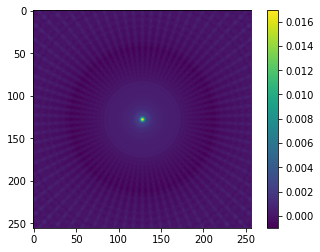

In [26]:
plt.imshow(op.adjoint(y_tf).numpy().real)
plt.colorbar()

In [27]:
class Gradient(tf.keras.layers.Layer):
    def __init__(self, m_op, shape_x, shape_y, depth):
        self.m_op = m_op
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape_x
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape_y
            )
        ]
        self.depth = depth +1
        self.trainable=False
    

    def __call__(self, x, y):
        x = tf.cast(x, tf.complex64)
        m = self.m_op.forward(x) 
        size = y.shape[1]
        res = m -  y
        grad = self.m_op.adjoint( res )
        return tf.cast(grad, tf.float32)

In [28]:
g = Gradient(op, [None, 256,256], [None, 4440], 0)

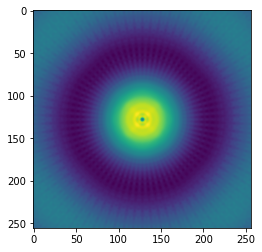

In [29]:
plt.imshow(g(x_tf[None, :,:], y_tf[None, :]).numpy().real)

In [30]:
gradient_layers = []
depth = 4
for i in range(depth):
    m_op = TF_nufft()
    nd, kd = (Nd[0]//2**i, Nd[1]//2**i), (Kd[0]//2**i, Kd[1]//2**i)
    print(nd, kd)
    sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i
    m_op.plan(uv[sel], nd, kd, Jd)
    gradient_layers.append( Gradient(m_op, [None, nd[0], nd[1]], [None, np.sum(sel)], i) )

 12%|█▏        | 533/4440 [00:00<00:00, 5328.71it/s]

(256, 256) (512, 512)


 12%|█▏        | 534/4414 [00:00<00:00, 5330.41it/s]

(128, 128) (256, 256)


 18%|█▊        | 535/2960 [00:00<00:00, 5347.71it/s]

(64, 64) (128, 128)


 35%|███▌      | 522/1480 [00:00<00:00, 5216.60it/s]

(32, 32) (64, 64)


100%|██████████| 1480/1480 [00:00<00:00, 5204.31it/s]


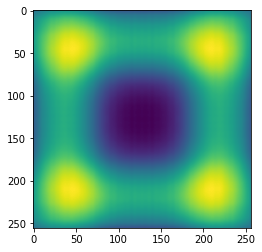

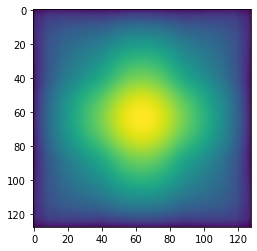

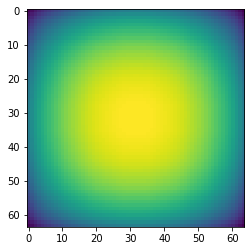

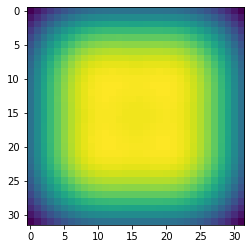

In [31]:
for i in range(depth):
    x_tf = tf.convert_to_tensor(np.ones((1, Nd[0]//2**i, Nd[1]//2**i)))
    y_tf = tf.convert_to_tensor(0j + np.ones((1,np.sum(np.linalg.norm(uv, axis=1) < np.pi / 2**i))))

    plt.imshow(gradient_layers[i](x_tf, y_tf).numpy().real)
    plt.show()

In [32]:
x_tf

<tf.Tensor: shape=(1, 32, 32), dtype=float64, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])>

In [33]:
# from src.network import medium_unet, small_unet

In [34]:
from src.sampling.uv_sampling import spider_sampling
uv = spider_sampling()

In [35]:
model = medium_unet(uv=uv, grad=True)

 11%|█         | 484/4440 [00:00<00:00, 4835.77it/s]

(256, 256) (512, 512)


 12%|█▏        | 533/4414 [00:00<00:00, 5328.10it/s]

(128, 128) (256, 256)


 18%|█▊        | 526/2960 [00:00<00:00, 5259.11it/s]

(64, 64) (128, 128)


 36%|███▌      | 536/1480 [00:00<00:00, 5359.69it/s]

(32, 32) (64, 64)


100%|██████████| 1480/1480 [00:00<00:00, 5316.11it/s]


In [36]:
model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4440, 1)]    0                                            
__________________________________________________________________________________________________
tf_op_layer_boolean_mask/Shape  [(3,)]               0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_boolean_mask/stride [(1,)]               0           tf_op_layer_boolean_mask/Shape[0]
__________________________________________________________________________________________________
tf_op_layer_boolean_mask/Shape_ [(3,)]               0           input_2[0][0]                    
_______________________________________________________________________________________________

In [37]:
import tensorflow as tf
import numpy as np

In [38]:
i=1
sel = np.linalg.norm(uv, axis=1) < np.pi / 2**i


In [39]:
y = tf.convert_to_tensor(np.ones((10, 4440,1)))

In [40]:
tf.boolean_mask(y, sel, axis=1)

<tf.Tensor 'boolean_mask_4/GatherV2:0' shape=(10, None, 1) dtype=float64>